# Improved background energy integration in Gammapy

This notebook checks and alternative background integratuon methode, implemented in `background.py` in the same folder. Instead of interpolating the differential counts and integrate the compute the cumulative sum of the background model in energy is computed and and interpolated directly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gammapy.data import DataStore
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.cube import make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, Map
from background import Background3DNew

For the check we load an example background model from the CTA 1DC data:

In [3]:
store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")
obs = store.get_observations([110380])[0]
bkg_3d = obs.bkg

Define the reference energies centers and bin edges:

In [4]:
e_edges = bkg_3d.data.axes[0].bins
e_center = bkg_3d.data.axes[0].log_center()

Here we plot the spectrum of the background model in the center of the FoV for varying number of evaluation bins:

In [5]:
bins_per_decades = [1, 3, 5, 7, 9, 11, 21, 31]

Text(0, 0.5, 'Bkg. rate (sr-1 s-1 MeV-1)')

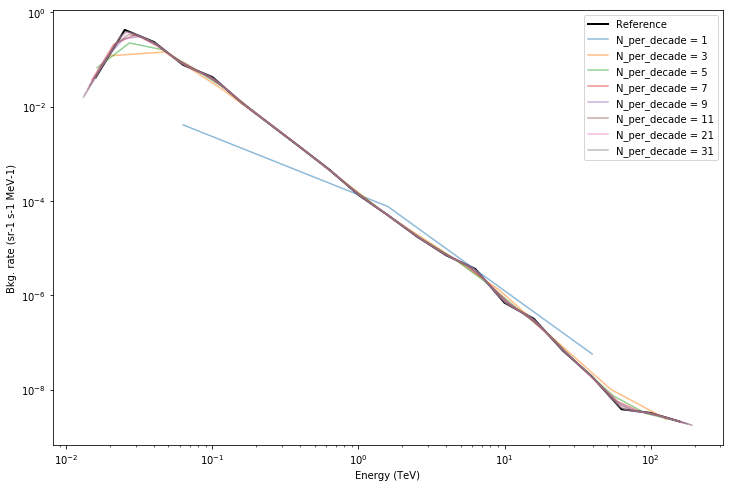

In [6]:
plt.figure(figsize=(12, 8))
bkg_profile = bkg_3d.evaluate(energy_reco=e_center, fov_lat=0 * u.deg, fov_lon=0 * u.deg)
plt.plot(e_center, bkg_profile, label="Reference", lw=2, color="k")

total_bkg = []

for bins_per_decade in bins_per_decades:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV"))
    
    n_bin = int((e_log_max - e_log_min) * bins_per_decade)
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
    
    bkg_profile_n_bins = bkg_3d.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    plt.plot(
        e_n_bins_center,
        (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1"),
        alpha=0.5,
        label=f"N_per_decade = {bins_per_decade}"
    )
    total_bkg.append(bkg_profile_n_bins.sum().to("s-1 sr-1"))
    
plt.loglog()
plt.legend()
plt.xlabel("Energy (TeV)")
plt.ylabel("Bkg. rate (sr-1 s-1 MeV-1)")

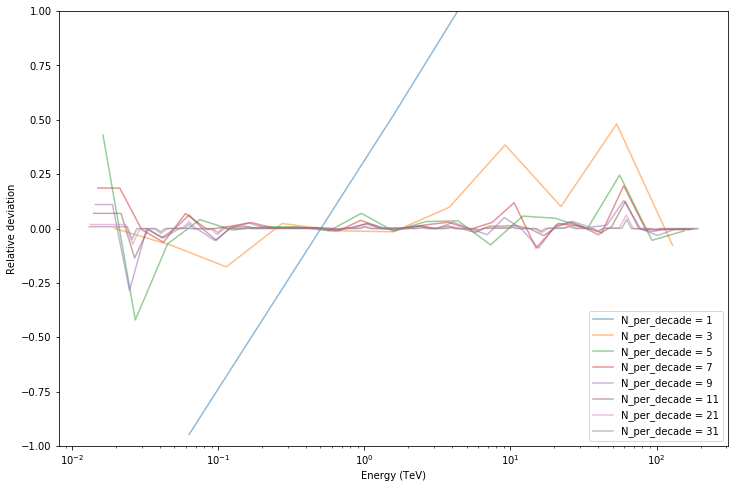

In [7]:
plt.figure(figsize=(12, 8))

for bins_per_decade in bins_per_decades:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV"))
    
    n_bin = int((e_log_max - e_log_min) * bins_per_decade)
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
      
    bkg_profile_n_bins = bkg_3d.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    
    value = (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1")
    
    ref = bkg_3d.evaluate(
        energy_reco=e_n_bins_center,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    
    diff = (value - ref) / ref
    
    plt.plot(
        e_n_bins_center, diff,
        alpha=0.5,
        label=f"N_per_decade = {bins_per_decade}"
    )
    
plt.semilogx()
plt.ylim(-1, 1)
plt.ylabel("Relative deviation")
plt.xlabel("Energy (TeV)")
plt.legend()

An the total energy integrated background counts against the number of bins used for evaluation:

Text(0, 0.5, 'Energy integrated background (sr-1 s-1)')

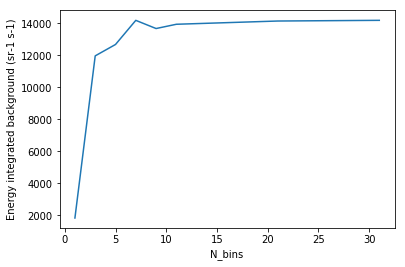

In [8]:
plt.plot(bins_per_decades, u.Quantity(total_bkg))
plt.xlabel("N_bins")
plt.ylabel("Energy integrated background (sr-1 s-1)")

In [9]:
bkg_3d_new = Background3DNew(
    energy_lo=bkg_3d.data.axes[0].lo,
    energy_hi=bkg_3d.data.axes[0].hi,
    fov_lon_lo=bkg_3d.data.axes[1].lo,
    fov_lon_hi=bkg_3d.data.axes[1].hi,
    fov_lat_lo=bkg_3d.data.axes[2].lo,
    fov_lat_hi=bkg_3d.data.axes[2].hi,
    data=bkg_3d.data.data,
)

Text(0, 0.5, 'Bkg. rate (sr-1 s-1 MeV-1)')

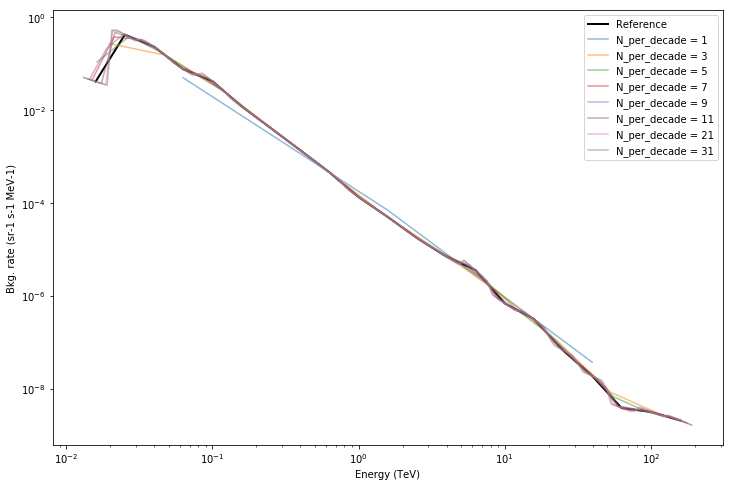

In [10]:
plt.figure(figsize=(12, 8))
bkg_profile = bkg_3d_new.evaluate(energy_reco=e_center, fov_lat=0 * u.deg, fov_lon=0 * u.deg)
plt.plot(e_center, bkg_profile, label="Reference", lw=2, color="k")

total_bkg = []

for bins_per_decade in bins_per_decades:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV") - 1)
    
    n_bin = int((e_log_max - e_log_min) * bins_per_decade)
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
    
    bkg_profile_n_bins = bkg_3d_new.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    plt.plot(
        e_n_bins_center,
        (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1"),
        alpha=0.5,
        label=f"N_per_decade = {bins_per_decade}"
    )
    total_bkg.append(bkg_profile_n_bins.sum().to("s-1 sr-1"))
    
plt.loglog()
plt.legend()
plt.xlabel("Energy (TeV)")
plt.ylabel("Bkg. rate (sr-1 s-1 MeV-1)")

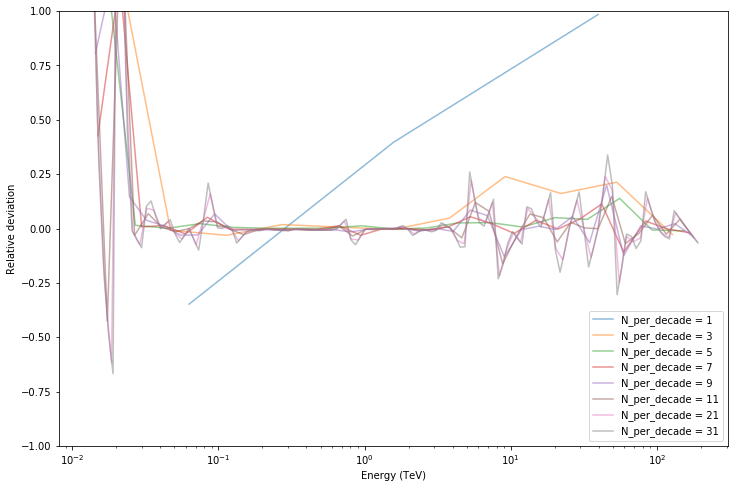

In [11]:
plt.figure(figsize=(12, 8))

for bins_per_decade in bins_per_decades:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV") - 1)
    
    n_bin = int((e_log_max - e_log_min) * bins_per_decade)
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
      
    bkg_profile_n_bins = bkg_3d_new.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    
    value = (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1")
    
    ref = bkg_3d.evaluate(
        energy_reco=e_n_bins_center,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    
    diff = (value - ref) / ref
    
    plt.plot(
        e_n_bins_center, diff,
        alpha=0.5,
        label=f"N_per_decade = {bins_per_decade}"
    )
    
plt.semilogx()
plt.ylabel("Relative deviation")
plt.xlabel("Energy (TeV)")
plt.ylim(-1, 1)
plt.legend()

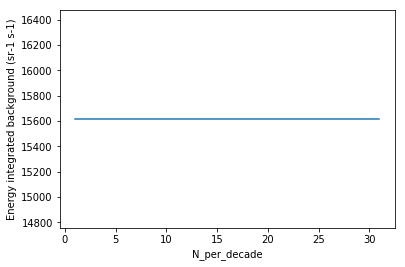

In [12]:
plt.plot(bins_per_decades, u.Quantity(total_bkg))
plt.xlabel("N_per_decade")
plt.ylabel("Energy integrated background (sr-1 s-1)")
plt.savefig(f"bkg-integration.png", dpi=300)

In [13]:
skydir = SkyCoord(0, 0, frame="galactic", unit="deg")
energy_axes = MapAxis.from_bounds(0.1, 100, 9, name="energy", unit="TeV")
geom = WcsGeom.create(skydir=skydir, binsz=0.02, width=(8, 8), axes=[energy_axes])

In [14]:
map_bkg_new = make_map_background_irf(skydir, 1 * u.h, bkg_3d_new, geom)
map_bkg = make_map_background_irf(skydir, 1 * u.h, bkg_3d, geom)

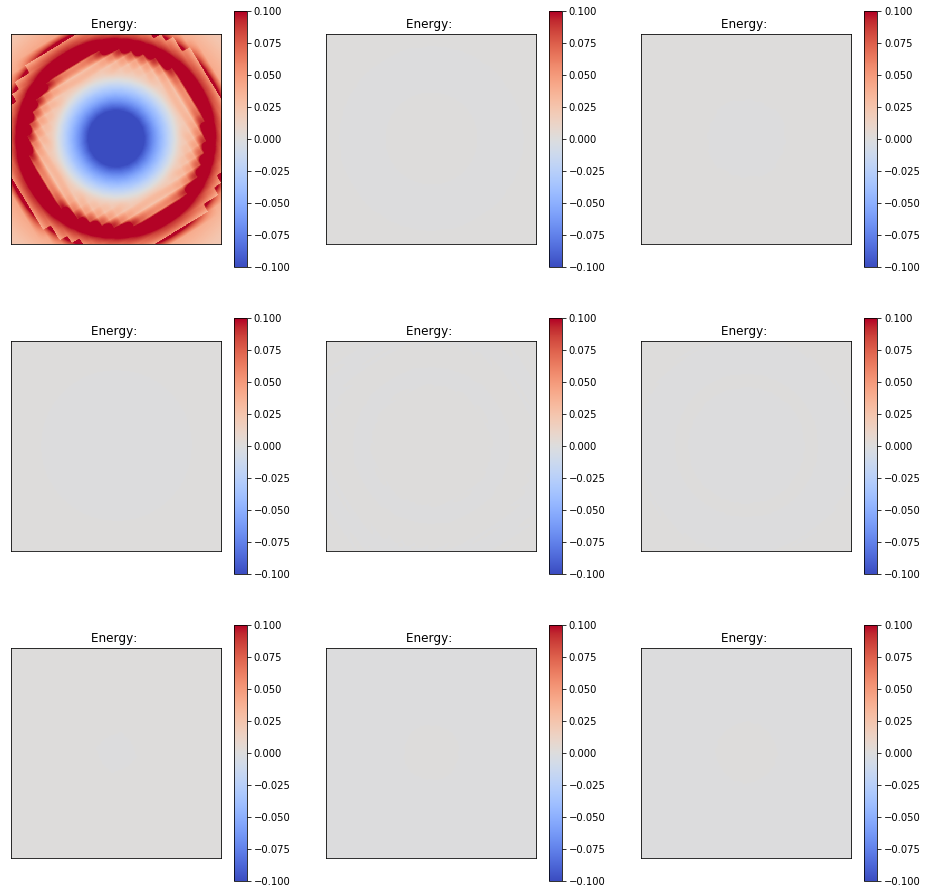

In [15]:
map_diff = (map_bkg_new - map_bkg)
plt.figure(figsize=(16, 16))

for idx in range(energy_axes.nbin):
    m = map_diff.get_image_by_idx((idx, ))
    ax = plt.subplot(3, 3, idx + 1)
    im = ax.imshow(m.data, vmin=-0.1, vmax=0.1, cmap="coolwarm", origin="lower")
    ax.set_title("Energy: ")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im)